In [1]:
# Load Packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline             
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import shap


/home/barsha/envs/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset used

Title: Resting State MRI data from healthy control (HC), Parkinson's disease with normal cognition (PD-NC), and Parkinson's disease with mild 
cognitive impairment (PD-MCI) cohorts.
This dataset is part of a longitudinal study investigating Parkinson's Disease (PD) and its associated cognitive impairments. Resting-state fMRI
data were collected from participants, including healthy controls (HC) and Parkinson's Disease patients with normal cognition (PD-NC) or mild
cognitive impairment (PD-MCI). The dataset is organized following the Brain Imaging Data Structure (BIDS) specifications.

Link: https://openneuro.org/datasets/ds005892/versions/1.0.0

Aaron S. Kemp, Journey Eubank, Yahya Younus, James E. Galvin, Fred W. Prior, and Linda J. Larson-Prior (2025). Resting State MRI data from healthy control (HC), Parkinson's disease with normal cognition (PD-NC), and Parkinson's disease with mild cognitive impairment (PD-MCI) cohorts. OpenNeuro. [Dataset] doi: doi:10.18112/openneuro.ds005892.v1.0.0

MR modality used: T1-weighted

Software used for segmentation: Freesurfer-7.4.1



# Load Dataset

In [3]:

df = pd.read_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/OnlyNormalized_volumes(CS).csv")

df = df[df["group"] != "PD-NC"]

In [4]:

# Binary label encoding
# Control -> 0, PD-NC  -> 1
df["label"] = df["group"].apply(lambda x: 0 if x == "Control" else 1)

# Drop non-feature columns
X = df.drop(columns=["Subjects", "group", "label"])
y = df["label"]


In [5]:
# Check the number of Healthy and PD-NC(Parkinson's with normal cognition)
df["group"].value_counts()

group
Control    22
PD-MCI     15
Name: count, dtype: int64

# Feature Selection

In [6]:
# Drop non-feature columns
X = df.drop(columns=['Subjects','Unnamed: 0','group','label'])
y = df["label"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [8]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=10)),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

pipe.fit(X_train, y_train)


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,steps,"[('scaler', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,score_func,<function f_c...x754d01b4cf70>
,k,10
,penalty,'l2'
,dual,False


In [9]:
selected_features_LR = X.columns[pipe.named_steps["selector"].get_support()]
print(selected_features_LR)


Index(['norm_Left-Lateral-Ventricle', 'norm_3rd-Ventricle',
       'norm_4th-Ventricle', 'norm_Brain-Stem', 'norm_Left-Amygdala',
       'norm_CSF', 'norm_Left-choroid-plexus', 'norm_Right-Lateral-Ventricle',
       'norm_Right-Cerebellum-White-Matter', 'norm_CC_Anterior'],
      dtype='object')


In [10]:
## Embedded methods (L1-regularized Logistic Regression)
pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    ))
])

pipe_l1.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0


In [16]:
coef = pipe_l1.named_steps["clf"].coef_[0]
selected_features_LASSO = X.columns[coef != 0]


In [15]:
# Tree-based feature importance (Random Forest / GB)

rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
SELECTED_FEATURES_RF = importances.sort_values(ascending=False).head(10)

In [14]:
# Wrapper methods (gold standard, but expensive)

from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=LogisticRegression(
        class_weight="balanced",
        max_iter=500
    ),
    n_features_to_select=10
)

rfe.fit(X_train, y_train)

selected_features_RFE = X.columns[rfe.support_]

In [17]:

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(f_classif, k=10)),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("Mean ROC-AUC:", scores.mean())


Mean ROC-AUC: 0.5599999999999999


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [35 36 37 38 39] 

In [20]:
selected_features_rfe = selected_features_RFE.tolist()
selected_features_lasso = selected_features_LASSO.tolist()
selected_features_lr = selected_features_LR.tolist()
selected_features_rf = SELECTED_FEATURES_RF.index.tolist()


type(selected_features_rfe), type(selected_features_lasso), type(selected_features_lr), type(selected_features_rf)

final_selected_features = selected_features_rfe + selected_features_lasso + selected_features_lr + selected_features_rf 
final_selected_features = set(final_selected_features)

In [19]:
df_list = df.columns.values.tolist()
len(df_list)
drop_features = set(df_list) - set(final_selected_features)
drop_features.remove("Unnamed: 0")
len(drop_features), len(final_selected_features), len(df_list)

(31, 31, 63)

In [21]:
drop_features

{'Subjects',
 'group',
 'label',
 'norm_BrainSegVolNotVent',
 'norm_CC_Central',
 'norm_CC_Mid_Anterior',
 'norm_CC_Mid_Posterior',
 'norm_CerebralWhiteMatterVol',
 'norm_CortexVol',
 'norm_Left-Caudate',
 'norm_Left-Hippocampus',
 'norm_Left-Pallidum',
 'norm_Left-Putamen',
 'norm_Left-VentralDC',
 'norm_Left-WM-hypointensities',
 'norm_Left-non-WM-hypointensities',
 'norm_Left-vessel',
 'norm_MaskVol',
 'norm_Right-Accumbens-area',
 'norm_Right-Caudate',
 'norm_Right-Hippocampus',
 'norm_Right-Inf-Lat-Vent',
 'norm_Right-VentralDC',
 'norm_Right-WM-hypointensities',
 'norm_Right-choroid-plexus',
 'norm_Right-non-WM-hypointensities',
 'norm_SubCortGrayVol',
 'norm_SupraTentorialVol',
 'norm_SupraTentorialVolNotVent',
 'norm_lhCortexVol',
 'norm_non-WM-hypointensities'}

# Training with the classification  model

In [44]:
# Drop the columns not in drop_features list
X = df.drop(columns=['Unnamed: 0','Subjects', 'group', 'label', 'norm_BrainSegVolNotVent', 'norm_CC_Central', 'norm_CC_Mid_Anterior', 'norm_CC_Mid_Posterior',
                     'norm_CerebralWhiteMatterVol', 'norm_CortexVol', 'norm_Left-Caudate', 'norm_Left-Hippocampus', 'norm_Left-Pallidum',
                     'norm_Left-Putamen', 'norm_Left-VentralDC', 'norm_Left-WM-hypointensities', 'norm_Left-non-WM-hypointensities', 
                     'norm_Left-vessel', 'norm_MaskVol', 'norm_Right-Accumbens-area', 'norm_Right-Caudate', 'norm_Right-Hippocampus',
                     'norm_Right-Inf-Lat-Vent', 'norm_Right-VentralDC', 'norm_Right-WM-hypointensities', 'norm_Right-choroid-plexus', 
                     'norm_Right-non-WM-hypointensities', 'norm_SubCortGrayVol', 'norm_SupraTentorialVol', 'norm_SupraTentorialVolNotVent',
                     'norm_lhCortexVol', 'norm_non-WM-hypointensities'])
y = df["label"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [46]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),

    "SVM (RBF)": Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        random_state=42
    ),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),

    "Bagging": BaggingClassifier(
        n_estimators=100,
        random_state=42
    )
}


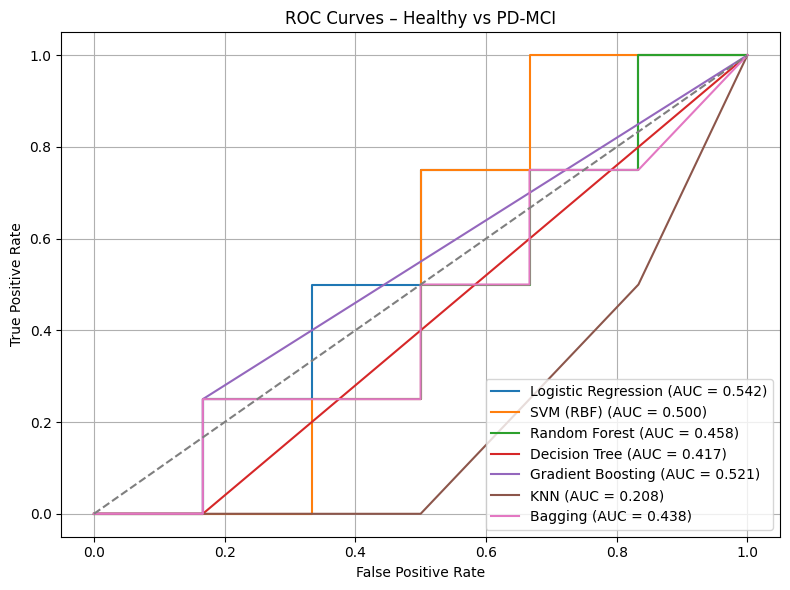

In [47]:
results = []

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    results.append({
    "Model": name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "F1-score": f1_score(y_test, y_pred)
    })

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")


results_df = pd.DataFrame(results)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Healthy vs PD-MCI")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Voting Classifier Results
Accuracy: 0.5
ROC-AUC: 0.5
F1-score: 0.2857142857142857


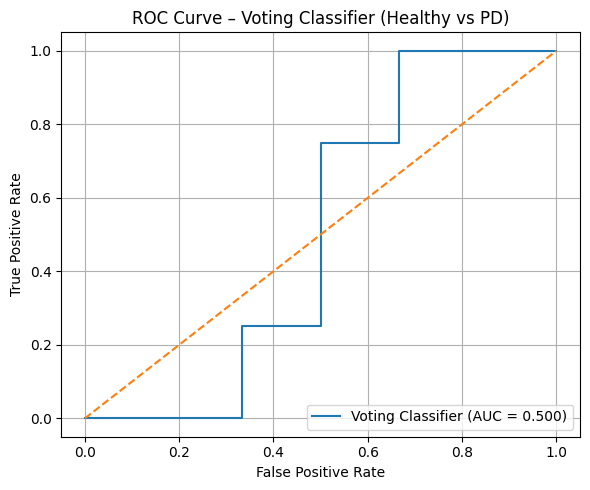

In [48]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("svm", models["SVM (RBF)"])
    ],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("F1-score:", f1_score(y_test, y_pred))

# Get ROC values
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier (Healthy vs PD)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Model: Logistic Regression


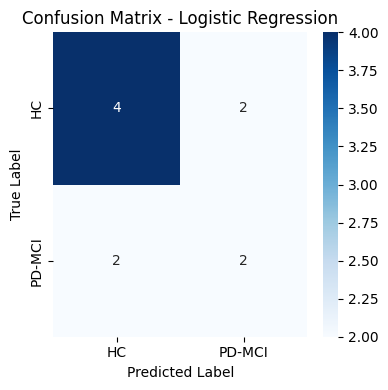


Classification Report - Logistic Regression
              precision    recall  f1-score   support

          HC       0.67      0.67      0.67         6
      PD-MCI       0.50      0.50      0.50         4

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10

Model: SVM (RBF)


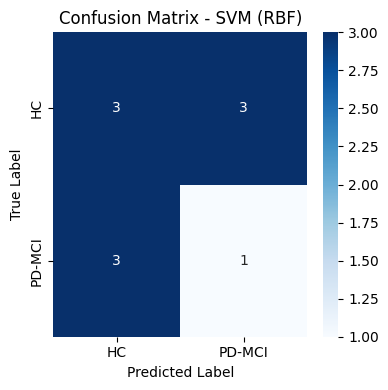


Classification Report - SVM (RBF)
              precision    recall  f1-score   support

          HC       0.50      0.50      0.50         6
      PD-MCI       0.25      0.25      0.25         4

    accuracy                           0.40        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.40      0.40      0.40        10

Model: Random Forest


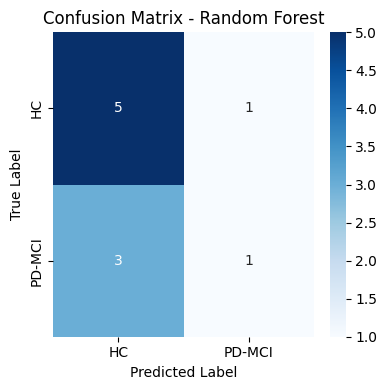


Classification Report - Random Forest
              precision    recall  f1-score   support

          HC       0.62      0.83      0.71         6
      PD-MCI       0.50      0.25      0.33         4

    accuracy                           0.60        10
   macro avg       0.56      0.54      0.52        10
weighted avg       0.57      0.60      0.56        10

Model: Decision Tree


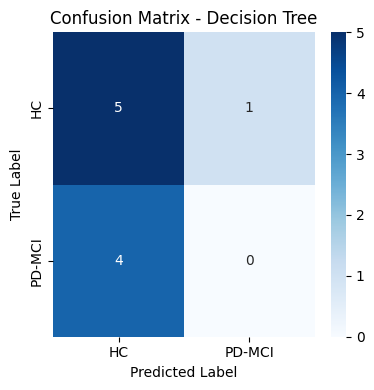


Classification Report - Decision Tree
              precision    recall  f1-score   support

          HC       0.56      0.83      0.67         6
      PD-MCI       0.00      0.00      0.00         4

    accuracy                           0.50        10
   macro avg       0.28      0.42      0.33        10
weighted avg       0.33      0.50      0.40        10

Model: Gradient Boosting


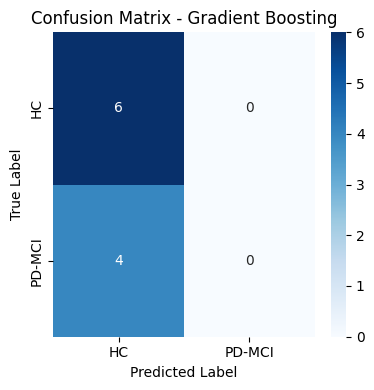


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

          HC       0.60      1.00      0.75         6
      PD-MCI       0.00      0.00      0.00         4

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.38        10
weighted avg       0.36      0.60      0.45        10

Model: KNN


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

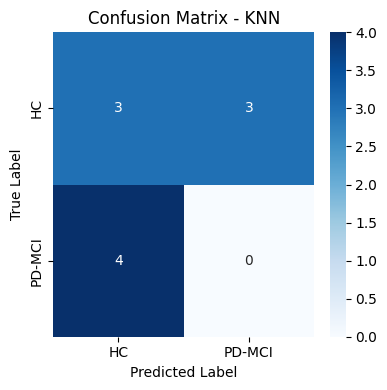


Classification Report - KNN
              precision    recall  f1-score   support

          HC       0.43      0.50      0.46         6
      PD-MCI       0.00      0.00      0.00         4

    accuracy                           0.30        10
   macro avg       0.21      0.25      0.23        10
weighted avg       0.26      0.30      0.28        10

Model: Bagging


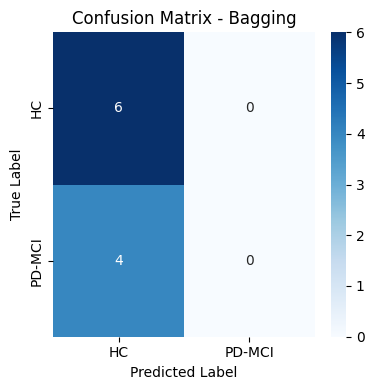


Classification Report - Bagging
              precision    recall  f1-score   support

          HC       0.60      1.00      0.75         6
      PD-MCI       0.00      0.00      0.00         4

    accuracy                           0.60        10
   macro avg       0.30      0.50      0.38        10
weighted avg       0.36      0.60      0.45        10



/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [49]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Prints confusion matrix and classification report
    """
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["HC", "PD-MCI"],
        yticklabels=["HC", "PD-MCI"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["HC", "PD-MCI"]
    ))

for name, model in models.items():
    print("=" * 60)
    print(f"Model: {name}")

    model.fit(X_train, y_train)
    evaluate_model(model, name, X_test, y_test)


# Stratified Cross Vlidation on the model

Mean AUC score : 0.51


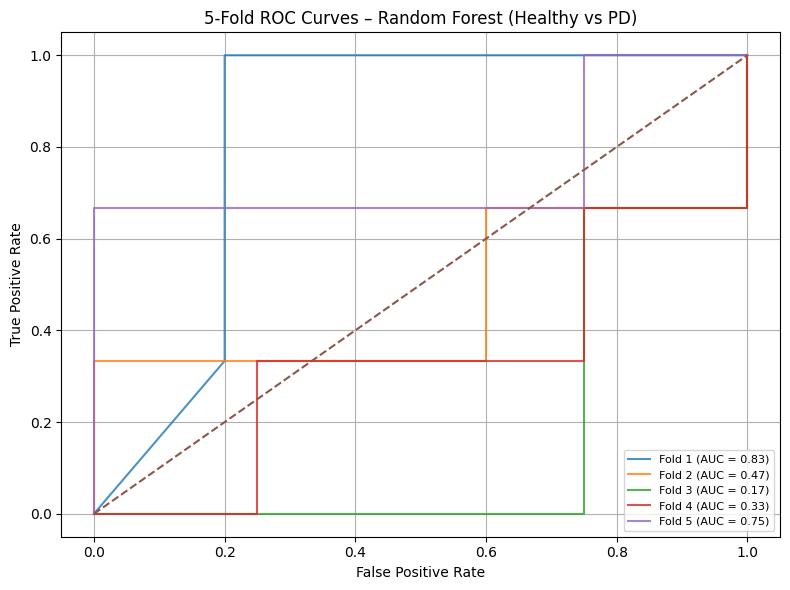

In [50]:
# Random  Forest

plt.figure(figsize=(8, 6))

aucs_RF = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Clone the model to avoid data leakage
    model = models["Random Forest"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_RF.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_RF))
# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Random Forest (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


Mean AUC score : 0.615


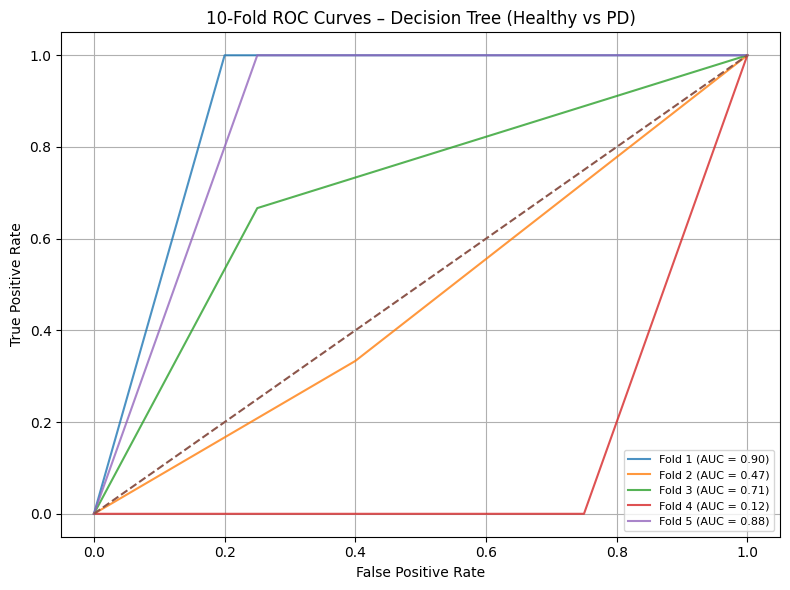

In [51]:
# Decision Tree

plt.figure(figsize=(8, 6))

aucs_DT = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Clone the model to avoid data leakage
    model = models["Decision Tree"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_DT.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

print("Mean AUC score :", np.mean(aucs_DT))# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("10-Fold ROC Curves – Decision Tree (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


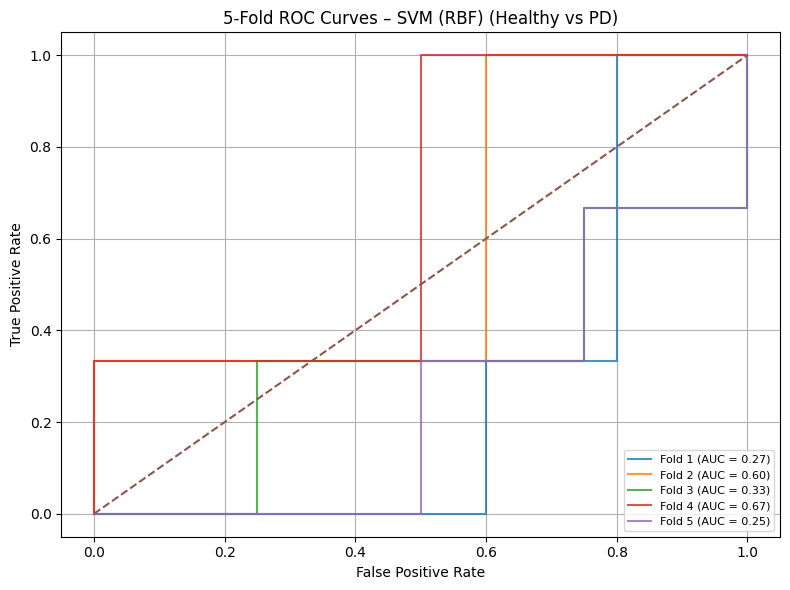

In [52]:
plt.figure(figsize=(8, 6))

aucs_SVM = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Clone the model to avoid data leakage
    model = models["SVM (RBF)"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_SVM.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – SVM (RBF) (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
print("Mean AUC score :", np.mean(aucs_SVM))# Chance line

Mean AUC score : 0.42333333333333334


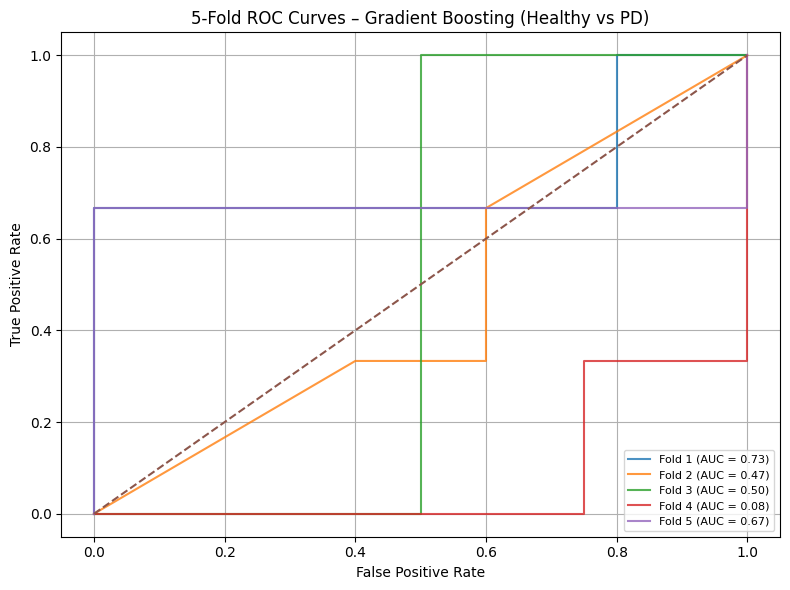

In [54]:
# Gradient Boosting

plt.figure(figsize=(8, 6))

aucs_GB = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    model = models["Gradient Boosting"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_GB.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Gradient Boosting (Healthy vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
print("Mean AUC score :", np.mean(aucs_GB))# Chance line

Mean AUC score : 0.48999999999999994


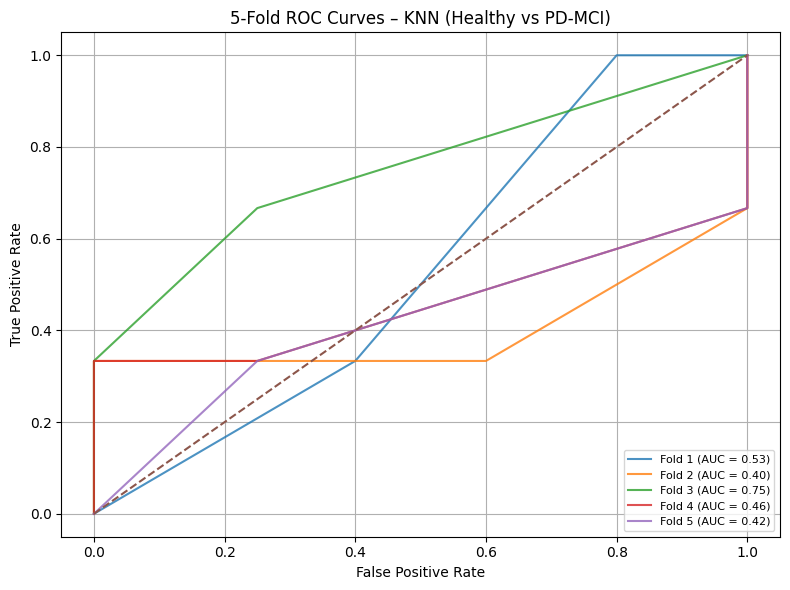

In [56]:
plt.figure(figsize=(8, 6))

aucs_knn = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Clone the model to avoid data leakage
    model = models["KNN"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_knn.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – KNN (Healthy vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
print("Mean AUC score :", np.mean(aucs_knn))# Chance line

Mean AUC score : 0.5116666666666666


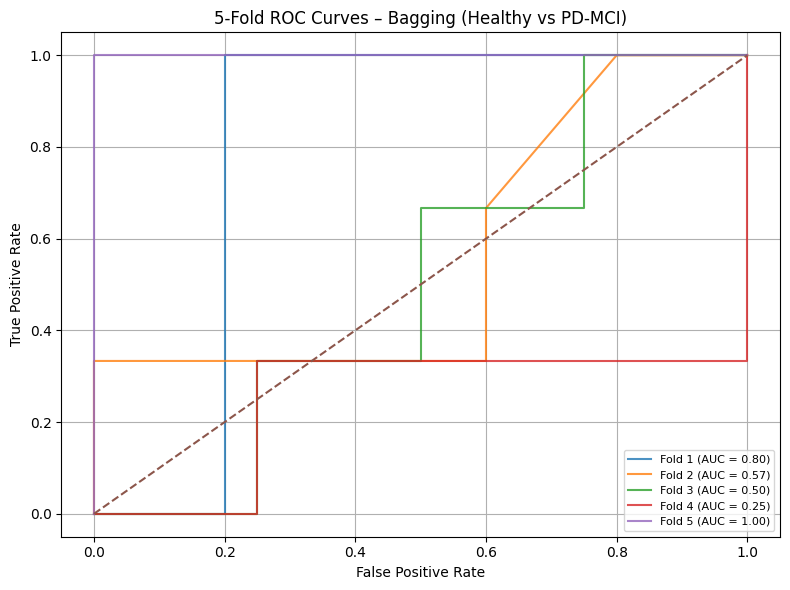

In [58]:
# Bagging

plt.figure(figsize=(8, 6))

aucs_bagging = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Clone the model to avoid data leakage
    model = models["Bagging"]
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs_bagging.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC Curves – Bagging (Healthy vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
print("Mean AUC score :", np.mean(aucs_bagging))# Chance line

Mean AUC score : 0.6233333333333333


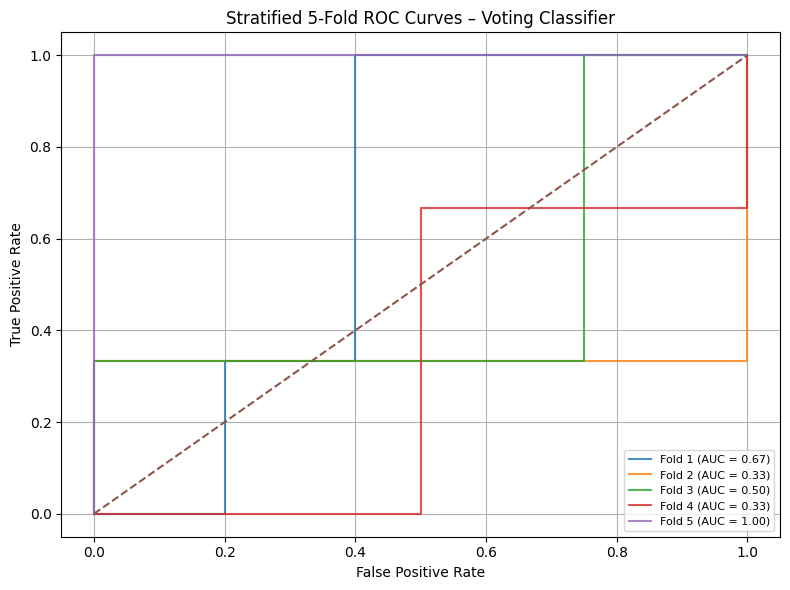

In [60]:
# Voting Classifier

plt.figure(figsize=(8, 6))

aucs = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # IMPORTANT: clone to avoid information leakage
    model = clone(voting_clf)
    model.fit(X_train_cv, y_train_cv)

    y_prob = model.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob)
    auc = roc_auc_score(y_test_cv, y_prob)
    aucs.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stratified 5-Fold ROC Curves – Voting Classifier")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
print("Mean AUC score :", np.mean(aucs))# Chance line

Mean AUC score : 0.5666666666666667


# Tune the models with nested cross-validation and SHAP for feature importance

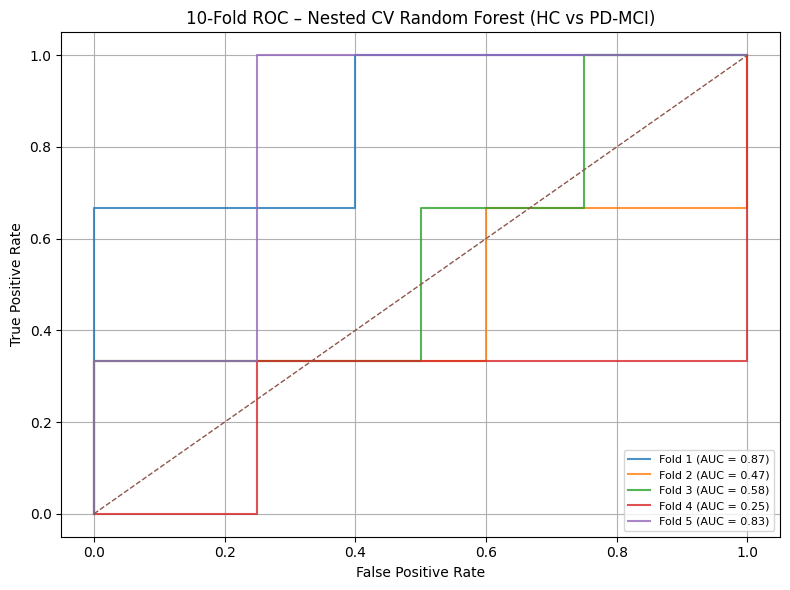

Random Forest Mean AUC: 0.600 ± 0.231


In [64]:
                                                 ###########  Random  Forest ###############

plt.figure(figsize=(8, 6))

aucs_rf = []

# Outer CV → model evaluation
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Inner CV → hyperparameter tuning
inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# Base RF model
rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", 0.3, 0.5]
}

import shap

shap_values_per_fold_rf = []
X_train_per_fold_rf = []
feature_names_rf = X.columns

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Grid search on training fold only
    grid = GridSearchCV(
        estimator=clone(rf_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_rf = grid.best_estimator_

    # ================= SHAP START =================
    explainer = shap.TreeExplainer(best_rf)

    # SHAP values for POSITIVE class (PD)
    shap_vals = explainer.shap_values(X_train)[1]

    shap_values_per_fold_rf.append(shap_vals)
    X_train_per_fold_rf.append(X_train)
    # ================= SHAP END ===================


    # Evaluate on held-out fold
    y_prob = best_rf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_rf.append(auc)

    plt.plot(
        fpr,
        tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("10-Fold ROC – Nested CV Random Forest (HC vs PD-MCI)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Random Forest Mean AUC: {np.mean(aucs_rf):.3f} ± {np.std(aucs_rf):.3f}")


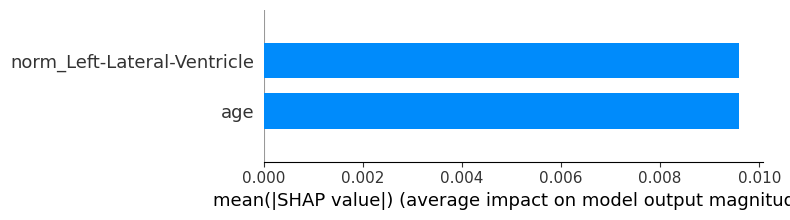

In [65]:

fold_id = 2
shap.summary_plot(
    shap_values_per_fold_rf[fold_id],
    features=None,
    feature_names=feature_names_rf,
    plot_type="bar",
    max_display=20,
    show=True
)


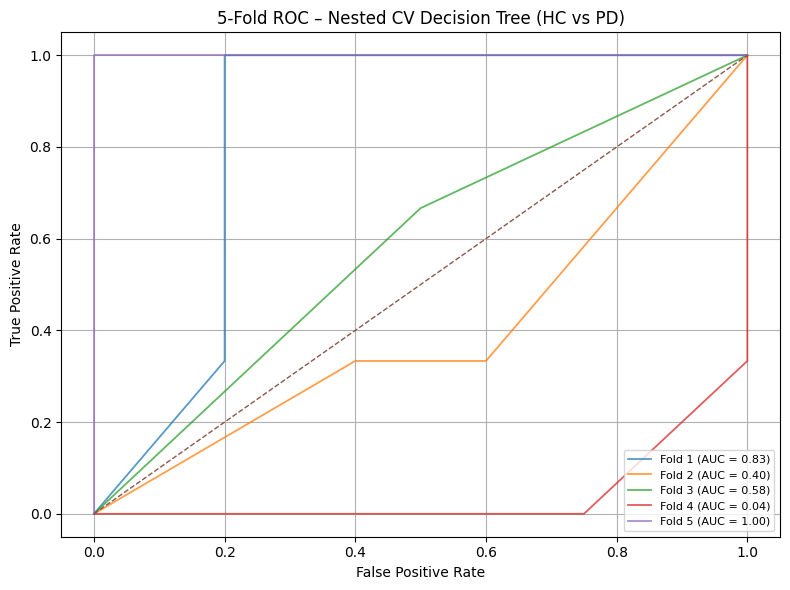

Decision Tree Mean AUC: 0.572 ± 0.335


In [71]:
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

aucs_DT = []

shap_values_per_fold_DT = []
X_train_per_fold_DT = []


plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    dt_base = DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=clone(dt_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_dt = grid.best_estimator_

    # ===== ROC =====
    y_prob = best_dt.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_DT.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

    # ===== SHAP (training data only) =====
    explainer = shap.TreeExplainer(best_dt)
    shap_vals = explainer.shap_values(X_train)

    # Binary classification → take class 1
    shap_vals = shap_vals[1]

    shap_values_per_fold_DT.append(shap_vals)
    X_train_per_fold_DT.append(X_train)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Decision Tree (HC vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Decision Tree Mean AUC: {np.mean(aucs_DT):.3f} ± {np.std(aucs_DT):.3f}")


/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 198.71it/s]
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 20.21it/s]
/home/barsha/envs/jupyter/lib/python3.10/site-packages/sklearn/utils/v

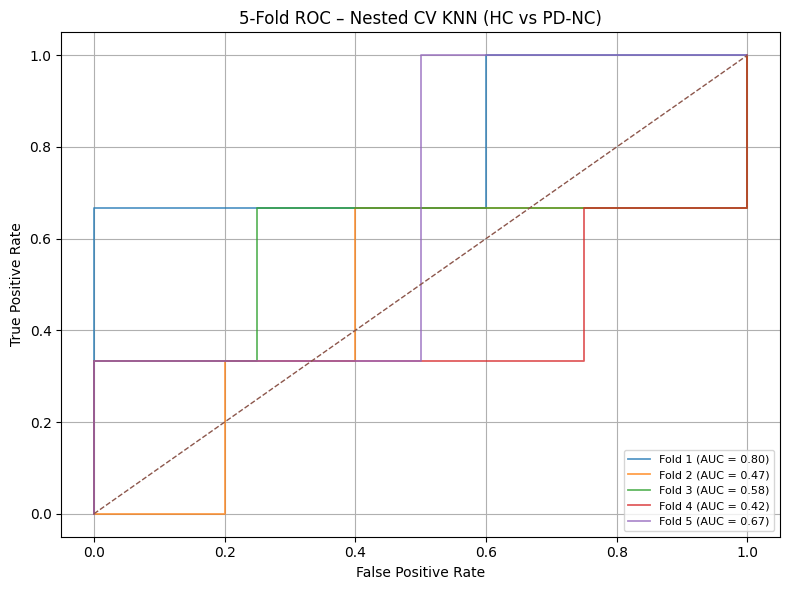

KNN Mean AUC: 0.587 ± 0.138


In [66]:
                                               ############### KNN #######################

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif)),
    ("clf", KNeighborsClassifier())
])


param_grid = {
    "select__k": [5, 10, 15, 20],          # NOT 30
    "clf__n_neighbors": [5, 7, 9, 11],    # stable for small datasets
    "clf__weights": ["distance"],         # mandatory
    "clf__metric": ["euclidean", "manhattan"]
}


plt.figure(figsize=(8, 6))

aucs_knn = []

# ⚠️ Use 5-fold outer CV for small N
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)
selected_k = []

shap_values_per_fold_knn = []
feature_names_per_fold_knn = []
X_train_sel_per_fold_knn = []


for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(pipe_knn),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_knn = grid.best_estimator_
    
    # Extract trained components (FIXED)
    selector = best_knn.named_steps["select"]
    knn_model = best_knn.named_steps["clf"]
    
    # Transform training data
    X_train_sel = selector.transform(X_train)
    X_train_sel_per_fold_knn.append(X_train_sel)
    
    # Selected feature names
    selected_features = X.columns[selector.get_support()]
    feature_names_per_fold_knn.append(selected_features)
    
    # 🔹 Background for SHAP (small subset for stability)
    background = shap.sample(X_train_sel, min(10, X_train_sel.shape[0]), random_state=42)
    
    # 🔹 Model-agnostic SHAP explainer (CORRECT for KNN)
    explainer = shap.KernelExplainer(
        knn_model.predict_proba,
        background
    )
    
    # 🔹 Explain a small subset
    X_explain = X_train_sel[:min(15, X_train_sel.shape[0])]
    
    # SHAP values for positive class (PD)
    shap_vals = explainer.shap_values(X_explain)[1]
    
    # 🔹 Convert to GLOBAL importance (required for bar plot)
    shap_vals_mean = np.mean(np.abs(shap_vals), axis=0)
    
    shap_values_per_fold_knn.append(shap_vals_mean)
  

    y_prob = best_knn.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    # inside outer CV loop
    selected_k.append(grid.best_params_["select__k"])
    
    aucs_knn.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV KNN (HC vs PD-NC)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"KNN Mean AUC: {np.mean(aucs_knn):.3f} ± {np.std(aucs_knn):.3f}")




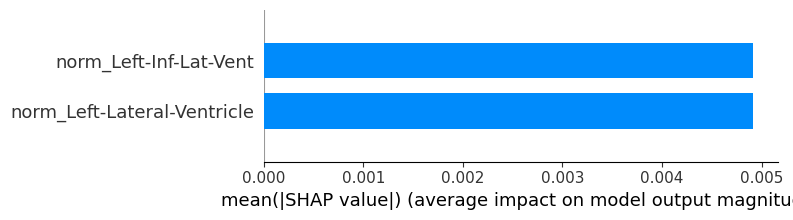

In [67]:
fold_id = 0

shap.summary_plot(
    shap_values_per_fold_knn[fold_id].reshape(1, -1),
    features=None,
    feature_names=feature_names_per_fold_knn[fold_id],
    plot_type="bar",
    max_display=20,
    show=True
)


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.89it/s]


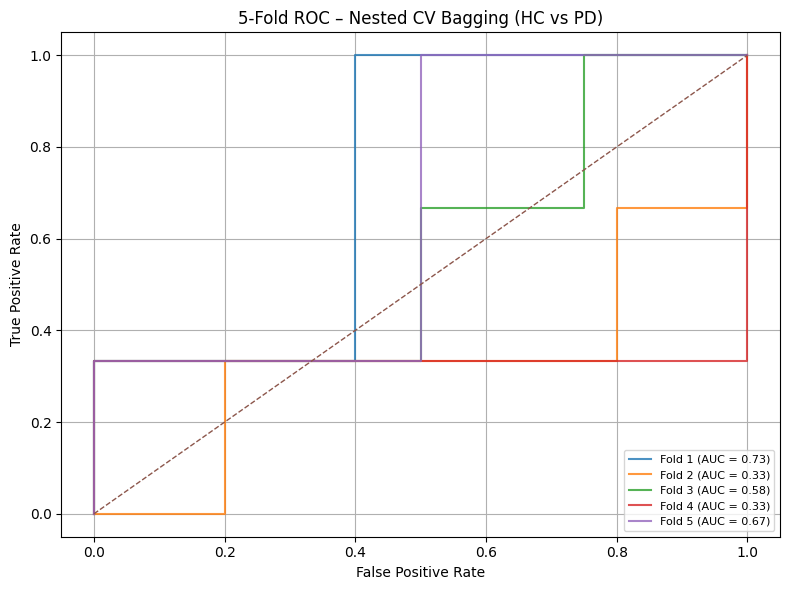

Bagging Mean AUC: 0.530 ± 0.167


In [68]:
# Bagging

plt.figure(figsize=(8, 6))

aucs_bagging = []

outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

bag_base = BaggingClassifier(
    random_state=42
)

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_samples": [0.7, 0.8, 1.0],
    "max_features": [0.7, 0.8, 1.0]
}

# SHAP storage
shap_values_per_fold_bag = []
X_train_per_fold_bag = []
feature_names_bag = X.columns

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 🔁 Inner CV (hyperparameter tuning)
    grid = GridSearchCV(
        estimator=clone(bag_base),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_bag = grid.best_estimator_

    # 🔍 Test fold evaluation
    y_prob = best_bag.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_bagging.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.5,
        alpha=0.8,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

    # ---------------- SHAP (training data only) ----------------
    # Use small background set (important for KernelExplainer)
    background = shap.sample(X_train, 50, random_state=42)

    explainer = shap.KernelExplainer(
        best_bag.predict_proba,
        background
    )

    shap_vals = explainer.shap_values(X_train, nsamples=100)

    shap_values_per_fold_bag.append(shap_vals)
    X_train_per_fold_bag.append(X_train)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Bagging (HC vs PD)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Bagging Mean AUC: {np.mean(aucs_bagging):.3f} ± {np.std(aucs_bagging):.3f}")


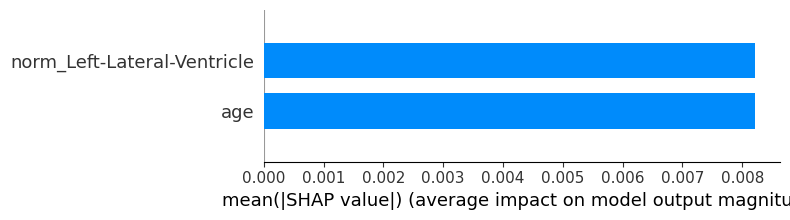

In [69]:
fold_id = 0

# Take SHAP values for PD class
shap_vals = shap_values_per_fold_bag[fold_id][1]

shap.summary_plot(
    shap_vals,
    features=None,
    feature_names=feature_names_bag,
    plot_type="bar",
    max_display=20,
    show=True
)


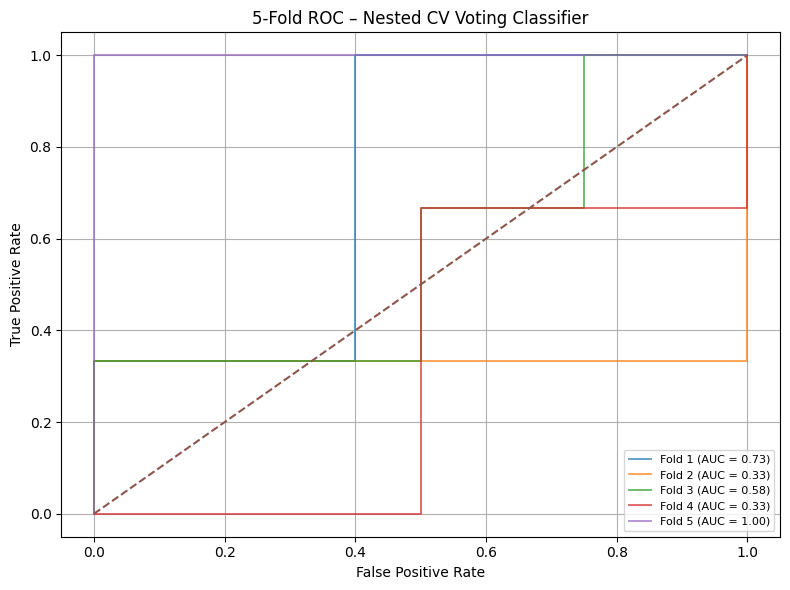

Voting Mean AUC: 0.597 ± 0.253


In [70]:
# Voting Classifier

plt.figure(figsize=(8, 6))

aucs_vote = []

outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# (Optional) tune only RF inside voting
param_grid = {
    "rf__max_depth": [None, 5, 10],
    "rf__n_estimators": [100, 200]
}

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(voting_clf),
        param_grid=param_grid,
        cv=inner_cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_vote = grid.best_estimator_

    y_prob = best_vote.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    aucs_vote.append(auc)

    plt.plot(
        fpr, tpr,
        lw=1.3,
        alpha=0.75,
        label=f"Fold {fold} (AUC = {auc:.2f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5-Fold ROC – Nested CV Voting Classifier")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Voting Mean AUC: {np.mean(aucs_vote):.3f} ± {np.std(aucs_vote):.3f}")
